# HOI Hub
## Welcome to the SIT ICT3104 Team 9 Human Object Interaction Hub Juypter Notebook

This notebook will take you through the steps of running an the different machine learning object detection model on video data.

Content Page <br/>
1.  [Data Exploration](#data) <br/>
2.  [Feature Extraction](#feature) <br/>
3.  [TSU](#tsu) <br/>
4.  [STEP](#step) <br/>
5.  [MS-TCT](#tct) <br/>
6.  [Static Code Analysis (SonarQube)](#qube) <br/>



# 1.0 Data Exploration
<a id='data'></a>

This section covers the different data types and files relevant to the model being used. Feel free to explore here. (R2) Things you will be able to in this section:

1.  Explore and Play Video Files
2.  Explore the different type of input files
3.  Explore other dataset files produced

In [1]:
#Common Imports
!pip install ipyfilechooser
!pip install wandb 
import os
from dotenv import load_dotenv

!wandb login a262be640ee86f4500481a88fd84c7ff1030e452
from ipyfilechooser import FileChooser
import ipywidgets as widgets
import sys
sys.path.append('./Commons')
import find_directory
import find_fileName
import matplotlib.pyplot as plt


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\user/.netrc


<h3>1.1 Setting up and Uploading your own files</h3>

*   First let's help you get your files into the notebook. We are using the "Data" folder located in your project folder to explore the sample videos.
*   You may also input your own sample videos for use in the object detection models in the later sections. This can be done by using locating the directory where the project is stored and copying or moving the desired videos to the "Data" folder directory.

In [ ]:
# US2
from pathlib import Path
def getProjectDir():
    proj_dir = Path.cwd().parent
    print(proj_dir)
    return str(proj_dir)

<h3>1.2 Playing video </h3>
Select which video types you would like to explore in the code cell below:

*   Depth_mp4: Black and white shades version of video input into the model
*   Videos_mp4: Video of the data being inputted into the model

In [ ]:
# US9
import os 
import ipywidgets as widgets

fileList = os.listdir(getProjectDir()+"\\data")
print(fileList)
a = widgets.Dropdown(options=fileList)
display(a)

In [ ]:
if a.value == "Depth_mp4" or a.value == "Videos_mp4":
    video_dir = os.listdir(f"{getProjectDir()}\\data\\{a.value}")
    b = widgets.Dropdown(options=video_dir)
    display(b)

In [ ]:
from IPython.display import Video
url = f"{getProjectDir()}\\data\\{a.value}\\{b.value}"
print(url)
# then display it
Video(url,embed=True)

# 2.0 Feature Extraction

The following section will depict the steps to extract features from videos. This feature extraction will be performed using v-iashin feature extraction which can be found https://github.com/v-iashin/video_features .
<a id='feature'></a>

### Prerequisites 
1. Store the videos that you wish to extract features from in the folder Data/Videos_MP4

<h3> 2.1 Create a Txt File containing all the video names </h3>

This cell will create a txt file based on all the video names within the Data/Videos_MP4 folder. This txt file will be used in the feature extraction step.

In [ ]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir("../Data/Videos_mp4") if isfile(join("../Data/Videos_mp4", f))]
with open('../Data/Videos_mp4/video_name.txt', 'w') as f:

    for name in onlyfiles:
        name = "../../../Data/Videos_mp4/" + name
        f.write(name)
        f.write('\n')
f.close()

In [ ]:
%cd ./FeatureExtraction/video_features

<h3> 2.2 Select the type of stream for feature extraction </h3>

Available values are RGB, Flow and null.


Null means that the stream will be default which will be RGB+Flow

In [ ]:
stream = widgets.Dropdown(
    options=['rgb', 'flow', 'null'],
    value='rgb',
    description='Stream:',
    disabled=False,
)
display(stream)


<h3>2.3 Extraction of Feature</h3>

The following cell will perform the feature extraction.

### Prerequisites
1. Ensure that the folder "ExtractedFeatures" exist in the path of "Codes/TSU/Toyota_Smarthome/pipline"

In [ ]:
chosen_stream = stream.value
%run main.py feature_type="i3d" device="cuda:0" file_with_video_paths="../../../Data/Videos_mp4/video_name.txt" output_path="../../../Codes/TSU/Toyota_Smarthome/pipline/ExtractedFeatures" on_extraction=save_numpy streams=$chosen_stream 

In [ ]:
%cd ../../

# 3.0 Training Model (TSU)
<a id='tsu'></a>

The following cells will depict the training of the model through the use of the Extracted Features completed previously. For further details, each cell will explain its functionality and purpose.

### Imports

The following cell will import the various libraries required by the training of model. If there is any libraries that is not installed. Please install into the virtual environment to ensure that the training of model is able to run successfully.

In [ ]:
# @title Run this!!
from os import listdir
from os.path import isfile, join
import csv
import os
import shutil
from shutil import SameFileError
import json
from pathlib import Path
import torch

In [ ]:
%cd ./TSU/Toyota_Smarthome/pipline

### 3.1 Curating the Extracted Features

The following cell will curate the Extracted Features into Features that the training requires.

Requirements:
1. Ensure that the Feature Extraction is completed **OR** Features are stored in the "ExtractedFeatures" folder in "Codes/TSU/Toyota_Smarthome/pipline"
2. Ensure that the folder named = "CuratedExtractedFeatures" exist in the directory "Codes/TSU/Toyota_Smarthome/pipline"

![image.png](../Codes/FeatureExtraction/video_features/sample/image1.jpeg)

In [ ]:
onlyfiles = [f for f in listdir("./ExtractedFeatures/i3d/") if isfile(join("./ExtractedFeatures/i3d/", f))]

f2 = open("./data/smarthome_CS_51.json")
data = json.load(f2)

diction = {}
RGBCount = 0

for i in onlyfiles:
  if i.__contains__("_rgb"):
    j = i.replace("_rgb","")
    shutil.copyfile("./ExtractedFeatures/i3d/"+i, "./CuratedExtractedFeatures/"+j)
    j = j.replace(".npy","")
    diction[j] = data.get(j)
    RGBCount += 1
print("Total RGB files extracted: " + str(RGBCount))
f2.close()

### 3.2 Compiling the Curated Extracted Features into a JSON 

The following cell will compile the curated features into a JSON object for training purposes.
1. Ensure that the folder named = "CuratedFeatures" exist in the directory "Codes/TSU/Toyota_Smarthome/pipline"
2. Ensure that the folder named = "data" exist in the directory "Codes/TSU/Toyota_Smarthome/pipline"

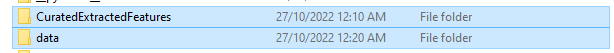

In [ ]:
with open('./data/smarthome_CS_32.json', 'w', encoding='utf-8') as f:
    json.dump(diction, f, ensure_ascii=False)
print("Smarthome_CS_32.json has been generated")

### 3.2 Selecting the variables


The following cell will require the user to select the specific value for training of the model.
1. Ensure that the folder named = "TrainedModel" exist in the current directory of the notebook and it is empty.
<br></br>

2. Mode {Unique Values}
	1. **There is 4 different modes RGB, FLOW, RGB+FLOW or FLOW+RGB**
<br></br>

3. Train {Boolean}
	1. **Determine if this is a training or testing.**
<br></br>

4. Epoch {Int}
	1.  **Defined as the total number of iterations of all the training data in one cycle for training the machine learning model.**
<br></br>

5. Batch Size {Int}
	1. **Defined as the number of training examples utilized in one iteration.**
<br></br>

6. Output {Folder}
	1. **This is the path of the output folder.**
<br></br>

In [ ]:
#Display Train Dropdown Menu
Train = widgets.Dropdown(
    options=[True, False],
    value=True,
    description='Train:',
    disabled=False,
)
display(Train)

#Display Mode Dropdown Menu
Mode = widgets.Dropdown(
    options=['rgb', 'flow', 'flow+rgb', 'rgb+flow'],
    value='rgb',
    description='Mode:',
    disabled=False,
)
display(Mode)

#Display Epoch Dropdown Menu
epoch = widgets.IntText(
    value=140,
    description='Epoch:',
    disabled=False
)
display(epoch)

#Display Batch Size Dropdown Menu
batchsize = widgets.IntText(
    value=1,
    description='Batch Size:',
    disabled=False
)
display(batchsize)




### 3.3 Selecting the output path

The following cell requires the user to pick the folder where they want to store the trained model at.

In [ ]:
filePathChooser = FileChooser()
filePathChooser.show_only_dirs = True
filePathChooser.default_path = os.getcwd()
filePathChooser.sandbox_path = os.getcwd()
display(filePathChooser)


In [ ]:

filePathInput = filePathChooser.selected
print(filePathInput)



### 3.4 Training the Model

The following cell will trained the model based on the variables that the user has selected previous.

In [ ]:
%run ./train.py \
-dataset TSU \
-mode $Mode.value \
-split_setting CS \
-model PDAN \
-train $Train.value \
-num_channel 512 \
-lr 0.0002 \
-kernelsize 3 \
-APtype map \
-epoch $epoch.value \
-batch_size $batchsize.value \
-comp_info TSU_CS_RGB_PDAN \
-load_model ./PreTrainedModel/PDAN_TSU_RGB\
-rgb_root ./CuratedExtractedFeatures \
-featurePath ./data/smarthome_CS_32.json \
-outputTrain $filePathInput

### 3.5 Evaluate Model

The following cell will evaluate the model and return the result in a CSV file located in EvaluateModel/Evaluation.csv

In [ ]:
%run test.py \
-dataset TSU \
-mode rgb \
-split_setting CS \
-model PDAN \
-train False \
-num_channel 512 \
-lr 0.0002 \
-kernelsize 3 \
-APtype map \
-epoch 5 \
-batch_size 2 \
-comp_info TSU_CS_RGB_PDAN \
-load_model ./PreTrainedModel/PDAN_TSU_RGB \
-rgb_root ./Data/smarthome_CS_32.json \
-featurePath ./CuratedExtractedFeatures\
-outputTest ./EvaluateModel 

# 4.0 Video Inference 
<a id='step'></a>

The following section will depict the steps taken to perform the video Inference for TSU.

### Limitations
1. The video inference can only be performed one at a time. Hence user have to select the video that they wish to perform inference on. 


### 4.1 Select the specific video

The following cells requires the user to pick the specific video that they want to do inference on

In [ ]:
vid = FileChooser('../../../../Data/Videos_mp4')
display(vid)

In [ ]:
videoPath = vid.selected
videoInput = vid.selected_filename


###  4.2 Select the output path

The following cell requires the user to pick the folder where they want to store the completed video inference at. 

There will be a folder named "InferencedVideos" available for users to store their videos if they wished to.

In [ ]:
filePathChooser = FileChooser()
filePathChooser.show_only_dirs = True
filePathChooser.default_path = os.getcwd()
display(filePathChooser)

In [ ]:
filePathInput = filePathChooser.selected_path

### 4.3 Video Inference Step

The following cell will run the video inference for TSU.

**Please ensure that you have completed the previous two steps to select the specific video and the output path.**

In [ ]:
%run inference.py \
-dataset TSU \
-mode rgb \
-split_setting CS \
-model PDAN \
-train False \
-num_channel 512 \
-lr 0.0002 \
-kernelsize 3 \
-APtype map \
-epoch 5 \
-batch_size 2 \
-comp_info TSU_CS_RGB_PDAN \
-load_model ./PreTrainedModel/PDAN_TSU_RGB \
-rgb_root ./data/smarthome_CS_51.json \
-featurePath ./CuratedExtractedFeatures \
-VideoInputTest $videoInput \
-video_path $videoPath \
-annotations ./Annotation \
-filepath $filePathInput

### 4.4 Step Imports
**Run the following cell before anything**

In [2]:
# %cd ../../../
!{sys.executable} -m pip install numpy opencv-python
!{sys.executable} -m pip install torch==1.8.2 torchvision==0.9.2 torchaudio===0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111
!{sys.executable} -m pip install ipywidgets

from pydoc import describe
from colorama import Style
from ipyfilechooser import FileChooser
import os
import ipywidgets as widgets
from IPython.display import HTML
import cv2
import numpy as np
import glob



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/lts/1.8/cu111


### 4.5 Step Inference

<h4>The following cell will execute inference on selected pretrain model.</h4>

1. Ensure that the folder named = "pretrained" exist in the Step directory of the notebook and it is empty.
<br></br>

2. Select Pretrained Model 
	1. **When clicked, displays all the available pretrained model in the pretrained folder in step**
<br></br>

3. Select Video Frame Folder 
	1. **Select a Folder containing video frames of desired video**
<br></br>

4. Select folder to save Inference Results
	1.  **Folder to save results from inferrence**
<br></br>


In [3]:
# Step Inference
preTrainedModelPicker = FileChooser(os.getcwd())
preTrainedModelPicker.filter_pattern = "*.pth"
preTrainedModelPicker.title = "Select pre-trained model"
preTrainedModelPicker.default_path = os.path.join(os.getcwd(),"step/pretrained")

fileList = os.listdir(os.path.join(os.getcwd(),"step/pretrained"))
print(fileList)
preTrainedDropDown = widgets.Dropdown(
    options=fileList,
    value=fileList[0],
    description='Select Pre-trained Model:',
    disabled=False,
)

fcSelectFrameFolder = FileChooser(os.getcwd())
fcSelectFrameFolder.show_only_dirs = True
fcSelectFrameFolder.title = "Select video frame folder to run inference on:"
fcSelectFrameFolder.default_path = os.path.join(os.getcwd(),'step/datasets/demo/frames')
fcSelectFrameFolder.sandbox_path = os.path.join(os.getcwd(),'step/datasets/demo/frames')

fcSelectFolderFileList = os.listdir(os.path.join(os.getcwd(),"step/datasets/demo/frames"))
fcSelectFolderDropdown = widgets.Dropdown(
    options=fcSelectFolderFileList,
    value=fcSelectFolderFileList[0],
    description='Select Folder:',
    disabled=False,
)
print (os.listdir(os.path.join(os.getcwd(),"step/datasets/demo/frames")))

fcSelectFrameResultFolder = FileChooser(os.getcwd())
fcSelectFrameResultFolder.show_only_dirs = True
fcSelectFrameResultFolder.title = "Select folder to save inference results to:"
fcSelectFrameResultFolder.default_path = os.path.join(os.getcwd(),'step/datasets/demo/results')



selectVideoFrameFolder = widgets.HBox([widgets.Label("Save inference result to:"),fcSelectFrameFolder])
confirmBtn2 = widgets.Button(description="Confirm")
resetBtn2 = widgets.Button(description="Reset")
buttonsHbox2 = widgets.HBox([confirmBtn2])
inferrenceOutput = widgets.Output()
vbox2 = widgets.VBox([preTrainedDropDown,fcSelectFolderDropdown,buttonsHbox2, inferrenceOutput])
def on_confirm_clicked2(b):
    with inferrenceOutput:
        # print("Running inference with pre-trained model: ", os.path.normpath( preTrainedModelPicker.selected))
        # print("Running inference on video frame folder: ", fcSelectFrameFolder.selected_path)
        # print("Saving results to: ", fcSelectFrameResultFolder.selected_path)
        # print(os.path.join(os.getcwd(),"step/datasets/demo/frames/"+str(fcSelectFolderDropdown.value)))
        # %run ./step/demo.py {os.path.join(fcSelectFrameFolder.selected_path,fcSelectFrameFolder.selected_filename)} {os.path.join(fcSelectFrameResultFolder.selected_path,fcSelectFrameResultFolder.selected_filename)} {os.path.normpath( preTrainedModelPicker.selected)}
        %run ./step/demo.py {os.path.join(os.getcwd(),"step/datasets/demo/frames/"+fcSelectFolderDropdown.value)} {os.path.join(os.getcwd(),'step/datasets/demo/results')} {os.path.join(os.getcwd(),"step/pretrained/"+preTrainedDropDown.value)}
        print("Inference completed!")
        print("Results saved to: ", "step\datasets\demo\results")
def on_reset_clicked2(b):
    inferrenceOutput.clear_output()
    fcSelectFrameFolder.reset()
    fcSelectFrameResultFolder.reset()
confirmBtn2.on_click(on_confirm_clicked2)
resetBtn2.on_click(on_reset_clicked2)
display(vbox2)

['ava_cls.pth', 'ava_step.pth', 'best.pth', 'i3d_kinetics.pth', 'mygpu.pth']
['1']



### 4.6 Step Frames Extraction<

<h4>The following cell will execute frame extraction on folder containing videos</h4>

1. Ensure that the folder named = "input" exists in the dataset Step directory of the notebook.
<br></br>

2. Select Folder containing video you wish to extract
	1. **Displays all the available pretrained model in the pretrained folder in step**
<br></br>
3. Click on confirm 
    1. **Takes the input provided and runs a script to extract frames from video**

3. Results Output
    1. **Frames of inputted videos are extracted at a rate of 30 frames per second**
    2. **Extracted frames can be located at step\datasets\ava.**

<br></br>

In [4]:
fcSelectVideo = FileChooser(os.getcwd())
fcSelectVideo.title = "Select video folder to run frame extraction on:"
fcSelectVideo.default_path = os.path.join(os.getcwd(),'step/datasets/input/')
fcResults = FileChooser(os.getcwd())
fcResults.show_only_dirs = True
fcResults.title = "Select folder to save frame extraction results to:"
fcResults.default_path = os.path.join(os.getcwd(),'step/datasets/ava/')


confirmBtn = widgets.Button(description="Confirm")
resetBtn = widgets.Button(description="Reset")
buttonsHbox = widgets.HBox([confirmBtn,resetBtn])


output = widgets.Output()
vbox = widgets.VBox([fcSelectVideo,fcResults,buttonsHbox, output])
def on_confirm_clicked(b):
    with output:
        print("Running inference on video : ", os.path.join(fcSelectVideo.selected_path,fcSelectVideo.selected_filename))
        print("Saving results to: ", fcResults.selected_path)
        %run ./step/scripts/extract_clips2.py {os.path.join(fcSelectVideo.selected_path,fcSelectVideo.selected_filename)} {os.path.join(fcResults.selected_path,fcResults.selected_filename)}
        output.clear_output()
        print("Frame extraction completed!") 
        
def on_reset_clicked(b):
    output.clear_output()
    fcSelectVideo.reset()
    fcResults.reset()
confirmBtn.on_click(on_confirm_clicked)
resetBtn.on_click(on_reset_clicked)

display(vbox)



### 4.7 Step Training/Testing prerequisite generate label for training and valuation
The following cell will transform training and valuation annotation files into pickle files 

1. Ensure that there is folder named 'label' in  the path 'step/datasets/ava/label/'.
<br></br>
![image](STEP/folder.png)
2. Select training CSV 
	1. **Select training annotation CSV from a list of annotation dataset to be transformed into a pickle file**
<br></br>
3. Select valuation CSV 
    1. **Select valuation annotation CSV from a list of annotation dataset to be transformed into a pickle file**

3. Results Output
    1. **Generates 2 pickle file for training at step\datasets\ava\label**
    <br></br>
![image](STEP/Untitled.png)

<br></br>

In [ ]:
# Step training generating label
# trainingCsv = FileChooser(os.getcwd())
# trainingCsv.filter_pattern = "*.csv"
# trainingCsv.title = "Select training CSV file"
# trainingCsv.default_path = os.path.join(os.getcwd(),"step/datasets/ava/label/")
valuationCsv = FileChooser(os.getcwd())
valuationCsv.filter_pattern = "*.csv"
valuationCsv.title = "Select valuation CSV file"
valuationCsv.default_path = os.path.join(os.getcwd(),"step/datasets/ava/label/")

trainingCSVdropdown = widgets.Dropdown(
    options=os.listdir(os.path.join(os.getcwd(),"step/datasets/ava/label/")),
    value=os.listdir(os.path.join(os.getcwd(),"step/datasets/ava/label/"))[0],
    description='Select Training CSV:',
    disabled=False,
)
valuationCSVdropdown = widgets.Dropdown(
    options=os.listdir(os.path.join(os.getcwd(),"step/datasets/ava/label/")),
    value=os.listdir(os.path.join(os.getcwd(),"step/datasets/ava/label/"))[0],
    description='Select Valuation CSV:',
    disabled=False,
)

trainingConfirmBtn = widgets.Button(description="Confirm")
trainingResetBtn = widgets.Button(description="Reset")
trainingButtonsHbox = widgets.HBox([trainingConfirmBtn])
trainingOutput = widgets.Output()
trainingVbox = widgets.VBox([trainingCSVdropdown,valuationCSVdropdown,trainingButtonsHbox, trainingOutput])
def on_training_confirm_clicked(b):
    with trainingOutput:
        print(trainingCSVdropdown.value)
        filePathTraining = os.path.join(os.getcwd(),"step/datasets/ava/label/"+trainingCSVdropdown.value)
        filePathValuation = os.path.join(os.getcwd(),"step/datasets/ava/label/"+valuationCSVdropdown.value)
        %run ./step/scripts/generate_label.py {filePathTraining}
        print("done generating training label")
        %run ./step/scripts/generate_label.py {filePathValuation}
        print("done generating valuation label")
       

trainingConfirmBtn.on_click(on_training_confirm_clicked)
display(trainingVbox)

### 4.8 Step Training 
The following cell will train the model.
<br></br>
<h4>Prerequisites</h4>
1) Training video frames are extracted and saved at Codes\STEP\datasets\ava\frames

![image](STEP/frames.png)
<br></br>
2) Training pickle file is generated 

![image](STEP/Untitled.png)
<br></br>


1. Epoch {Int}
	*  **Defined as the total number of iterations of all the training data in one cycle for training the machine learning model.**
<br></br>

2. Batch Size {Int}
	* **Defined as the number of training examples utilized in one iteration.**
<br></br>

3. Worker {Int}
	 **Defined as the number of worker threads**


<br></br>

In [ ]:
# Step Training Model
from cProfile import label
data_root="step/datasets/ava/"
save_root="step/datasets/ava/cache/"
pretrain_path="step/pretrained/ava_cls.pth"

name="STEP"
base_net="i3d"
det_net="two_branch"
resume_path="Auto"

T=3
max_iter=3    # index starts from 1
iterative_mode="temporal"
anchor_mode="1"
temporal_mode="predict"
pool_mode="align"
pool_size=7

# training schedule
num_workers=4
max_epochs=14
batch_size=1
optimizer="adam"
base_lr=7.5e-5
det_lr0=1.5e-4
det_lr=7.5e-4
save_step=11465
print_step=500
scheduler="cosine"
milestones="-1"
warmup_iters=1000

# losses
dropout=0.3
fc_dim=256
lambda_reg=5
lambda_neighbor=1
cls_thresh="0.2,0.35,0.5"
reg_thresh="0.2,0.35,0.5"
max_pos_num=5
neg_ratio=2
NUM_SAMPLE=-1
topk=300
evaluate_topk=300

# data augmentation / normalization
scale_norm=2    # for i3d
do_flip="True"
do_crop="True"
do_photometric="True"
do_erase="True"
freeze_affine="True"
freeze_stats="True"
outputTrain = widgets.Output()
dataFileFolderPath = FileChooser(os.getcwd())
dataFileFolderPath.title = "Select data file folder"
dataFileFolderPath.default_path = os.path.join(os.getcwd(),"step/datasets/ava/")
dataFileFolderPath.show_only_dirs = True
saveFileFolderPath = FileChooser(os.getcwd())
saveFileFolderPath.title = "Select save file folder"
saveFileFolderPath.default_path = os.path.join(os.getcwd(),"step/datasets/ava/cache/")
saveFileFolderPath.show_only_dirs = True
epochLabel = widgets.Label("Epoch")
epochInput = widgets.IntText();
epochInput.value = 14
batchLabel = widgets.Label("Batch")
batchInput = widgets.IntText();
batchInput.value = 1
workerLabel = widgets.Label("Worker")
workerInput = widgets.IntText();
workerInput.value = 4


dataFilePath = os.path.join(os.getcwd(),"step/datasets/ava/")
saveFilePath = os.path.join(os.getcwd(),"step/datasets/ava/cache/")
pretrainFilePath = os.path.join(os.getcwd(),"step/pretrained/ava_cls.pth")

epochHbox = widgets.HBox([epochLabel,epochInput])
batchHbox = widgets.HBox([batchLabel,batchInput])
workerHbox = widgets.HBox([workerLabel,workerInput])
startButton = widgets.Button(description="Start")
startButton.style.button_color = 'lightgreen'
startButton.style.font_weight = 'bold'
def startOnClick(b):
    with outputTrain:
        %run ./step/train.py --data_root $dataFilePath --save_root $saveFilePath \
        --name $name --pretrain_path $pretrainFilePath --resume_path $resume_path \
        --base_net $base_net --det_net $det_net --max_iter $max_iter --T $T \
        --iterative_mode $iterative_mode --anchor_mode $anchor_mode --anchor_mode $anchor_mode --temporal_mode $temporal_mode \
        --pool_mode $pool_mode --pool_size $pool_size --save_step $save_step --topk $topk --evaluate_topk $evaluate_topk \
        --num_workers $workerInput.value --max_epochs $epochInput.value --batch_size $batchInput.value --print_step $print_step \
        --optimizer $optimizer --base_lr $base_lr --det_lr $det_lr --det_lr0 $det_lr0 --milestones $milestones \
        --scale_norm $scale_norm --do_flip $do_flip --do_crop $do_crop --do_photometric $do_photometric --do_erase $do_erase \
        --fc_dim $fc_dim --dropout $dropout --NUM_SAMPLE $NUM_SAMPLE --scheduler $scheduler --warmup_iters $warmup_iters \
        --cls_thresh $cls_thresh --reg_thresh $reg_thresh --max_pos_num $max_pos_num --neg_ratio $neg_ratio \
        --freeze_affine $freeze_affine --freeze_stats $freeze_stats --lambda_reg $lambda_reg --lambda_neighbor $lambda_neighbor
startButton.on_click(startOnClick)
display(epochHbox, batchHbox, workerHbox, startButton, outputTrain)

### 4.8 Step Testing
<h4>The following cell would perform testing of selected pretrained model.</h4>
<h4>Prerequisites</h4>

1) Valuation pickle file is generated 

1) Valuation pickle file is generated 

![image](STEP/Untitled.png)
<br></br>

1. Select Pretrain file
    *   **Select pretrain model to be tested**
2. Output 
    *   **Testing output result would be saved to Codes\STEP\datasets\ava\cache completion of testing.**

In [ ]:
pretrainedTestFs = FileChooser(os.getcwd())
pretrainedTestFs.title = "Select pretrained file"
pretrainedTestFs.default_path = os.path.join(os.getcwd(),"step/pretrained/")
pretrainedTestFs.filter_pattern = "*.pth"
testOutput = widgets.Output()
testButton = widgets.Button(description="Test")
testButton.style.button_color = 'lightgreen'
testButton.style.font_weight = 'bold'

selectPretrainedLabel = widgets.Label("Select pretrained file to do testing:")
selectPretrainedLabel.style.font_weight = 'bold'
pretrainedFileList = os.listdir(os.path.join(os.getcwd(),"step/pretrained/"))
preTrainedDropDown = widgets.Dropdown(
    options=pretrainedFileList,
    value=pretrainedFileList[0],
    description='Pretrained:',
    disabled=False,
)
def testOnClick(b):
    with testOutput:
        testingFilePath = os.path.join(os.getcwd(),"step/pretrained/",preTrainedDropDown.value)
        %run ./step/test.py {testingFilePath}
        
testButton.on_click(testOnClick)
    
display(selectPretrainedLabel,preTrainedDropDown, testButton, testOutput)

<h3> 4.5 Data Visualization</h3>
In this Section, you will be able to view the wandb logs visualised through plotly.   

<br>

Select wandb folder:
 1. **Select wandb folder logs to visualise pertaining to timestamp**
<br> 

In [ ]:
import glob
import pandas as pd
#ipyfilepicker
wandbFolderPicker = FileChooser(os.getcwd())
wandbFolderPicker.title = "Select wandb folder"
wandbFolderPicker.default_path = os.path.join(os.getcwd(),"TSU/Toyota_Smarthome/pipline/","wandb_result")
wandbFolderPicker.show_only_dirs = True
wandbFolderPicker.sandbox_path = os.path.join(os.getcwd(),"TSU/Toyota_Smarthome/pipline/","wandb_result")
wandbFolderPicker.use_dir_icons = True
wandFolderPath = ""

visualiseBtn = widgets.Button(description="Visualise")
wandboutput = widgets.Output()
def visualiseOnClick(b):
    with wandboutput:
        wandFolderPath = os.path.join(os.getcwd(),"Code/TSU/Toyota_Smarthome/pipline/","wandb_result",wandbFolderPicker.selected_path)
        print(wandFolderPath)
        
visualiseBtn.on_click(visualiseOnClick)
display(wandbFolderPicker, visualiseBtn, wandboutput)

In [ ]:
wandbFolderPath = os.path.join(os.getcwd(),"wandb_result",wandbFolderPicker.selected_path)
print(wandbFolderPath)

In [ ]:
import plotly.express as px
for files in os.listdir(wandbFolderPath):
            if files.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(wandbFolderPath,files))
                    #covert timestamp to datetime
                    df['_timestamp'] = pd.to_datetime(df['_timestamp'], unit='s')
                    print(df['_timestamp'])
                    #linechart
                    fig = px.line(df, x='_timestamp', y='loss', title='Train Loss')
                    fig2 = px.line(df, x='_timestamp', y='accuracy', title='accuracy')
                    fig.show()
                    fig2.show()

                    
                except:
                    print("")


# 5.0 MS-TCT
<a id='tct'></a>
Please satisfy the following dependencies to train MS-TCT correctly:

1. pytorch 1.9
2. python 3.8
3. timm 0.4.12
4. pickle5
5. scikit-learn
6. numpy

<br>
This section uses the following repository: https://github.com/dairui01/MS-TCT

<h3> 5.1 Feature Extraction using PyTorch-i3d</h3>
In this section we will be extracting the numpy file for the I3D model. You may select your folder directory where the model is stored to extract the features.
By default a few fine-tuned RGB and Flow I3D models are available in the model directory under <b>/MS_TCT/pytorch-i3d-master/models</b> (rgb_charades.pt and flow_charades.pt).

**extract_features.py** contains the code to load a pre-trained I3D model and extract the features and save the features as numpy arrays. The **charades_dataset_full.py** script loads an entire video to extract per-segment features.

This code was written for PyTorch 0.3. Version 0.4 and newer may cause issues.



*   You may be required to download the charades datasets from https://prior.allenai.org/projects/charades

In [ ]:
import ipywidgets as widgets
from ipyfilechooser import FileChooser
mode  = widgets.Dropdown(
    options=['rgb','flow'],
    value='rgb',
    description='Mode:',
    disabled=False,
)

load_model = FileChooser(os.getcwd())
load_model.title = "Select model"
load_model.default_path = os.path.join(os.getcwd(),"MS_TCT/pytorch-i3d-master/models/")
load_model.show_only_dirs = False

gpu_select = widgets.Dropdown(
    options=['0','1'],
    value='0',
    description='GPU:',
    disabled=False,
)

save_directory = FileChooser(os.getcwd())
save_directory.title = "Select save directory"
save_directory.default_path = os.path.join(os.getcwd(),"MS_TCT/")
save_directory.show_only_dirs = True

tct_button = widgets.Button(description="Extract")

tct_output = widgets.Output()

def tct_on_click(b):
    with tct_output:
        %run ./MS_TCT/pytorch-i3d-master/extract_features.py \
        -mode rgb \
        -load_model $load_model.value \
        -root ./MS_TCT/data/charades.json \
        -gpu $gpu_select.value \
        -save_dir $save_directory.value

tct_button.on_click(tct_on_click)
display(mode,load_model,gpu_select,save_directory,tct_button,tct_output)


In [ ]:
import os
print(os.getcwd())
%run ./MS_TCT/pytorch-i3d-master/extract_features.py \
-mode rgb \
-load_model $load_model.value \
-root ./MS_TCT/data/charades.json \
-gpu $gpu_select.value \
-save_dir $save_directory.value

<h3>5.2 Training</h3>
In this section we will be training the model using the extracted features.

Like the previous works (e.g. TSU, PDAN), MS-TCT is built on top of the pre-trained I3D features. Thus, feature extraction is needed before training the network.

RGB and Optical flow are following the same training process. Both modalities can be added in the logit-level to have the two-stream performance (i.e., late fusion).</h4>


Quick Start
1.   Change the **rgb_root** to the extracted feature path in the **train.py**.
2.   Select the appropriate parameters as args to start the training using the interface provided in the cell below.  

Training Parameters are as followed ( Default Skip 0 )
1. Dataset - **Name of the Dataset to train.**

2. Mode - **Inference Metric Methods: rgb or flow.**

3. Model - **Select Model To Train.**

4. Train - **Train or Test.**

5. Num Clips - **Number of Clips for image processing.**

6. Learning Rate - **Learning rate indicates the step size that gradient descent takes towards local optima.**

7. Compute Info - **Compute Info: Information of the computation.**

8. Epoch - **Number of iterations for the training process in Machine Learning.**

9. Uni Size: **Uni Size**

10. Alpha Learning Rate: **Alpha Learning Rate**

11. Beta Learning Rate: **Beta Learning Rate**

12. Batch_Size: **Number of samples that is used in one epoch**

In [ ]:
import ipywidgets as widgets


datasetDropdown = widgets.Dropdown(
    options=['charades'],
    value='charades',
    description='Dataset:',
    disabled=False,
)

dropdownOptions = ['rgb','flow']

dropdown = widgets.Dropdown(
    options=dropdownOptions,
    value= dropdownOptions[0],
    description='Number:',
    disabled=False,
)
MST_train_dropdown = widgets.Dropdown(
    options=['True','False'],
    value='True',
    description='MST_train:',
    disabled=False,
)
num_clip_input = widgets.FloatText(
    value=1,
    description='num_clip:',
    disabled=False
)
learning_rate_input = widgets.FloatText(
    value=0.0001,
    description='learning_rate:',

    disabled=False
)
comp_info_input = widgets.Dropdown(
    options=['True','False'],
    value='True',
    description='comp_info:',
    disabled=False,
)
epoch_input = widgets.FloatText(
    value=1,
    description='epoch:',
    disabled=False
)
unisize = widgets.Dropdown(
    options=['True','False'],
    value='True',
    description='unisize:',
    disabled=False,
)
alpha_l = widgets.FloatText(
    value=0.1,
    description='alpha_l:',
    disabled=False
)
beta_l = widgets.FloatText(
    value=0.1,
    description='beta_l:',
    disabled=False
)
batch_size = widgets.IntText(
    value=32,
    description='batch_size:',
    disabled=False
)

run_button = widgets.Button(description="Run")
tct_output = widgets.Output()

def on_button_clicked(b):
    with tct_output:
        %run ./MS_TCT/train.py \
        -dataset $datasetDropdown.value \
        -mode $dropdown.value \
        -model MS_TCT \
        -train $MST_train_dropdown.value \
        -num_clips $num_clip_input.value \
        -skip 0 \
        -lr $learning_rate_input.value \
        -comp_info $comp_info_input.value \
        -epoch $epoch_input.value \
        -unisize $unisize.value \
        -alpha_l $alpha_l.value \
        -beta_l $beta_l.value \
        -batch_size $batch_size.value
display(datasetDropdown,dropdown,MST_train_dropdown,num_clip_input,learning_rate_input,comp_info_input,epoch_input,unisize,alpha_l,beta_l,batch_size,run_button,tct_output)
run_button.on_click(on_button_clicked)

# 6.0 SonarQube
<a id="qube"></a>
SonarQube is an open-source platform developed by SonarSource for continuous inspection of code quality to perform automatic reviews with static analysis of code to detect bugs and code smells on 29 programming language. Tool from https://www.sonarqube.org/

The screenshot below shows the result of the static code analysis done by SonarQube, a Software to perform static code analysis to detect bug and vulnerabilities.

![image](../Codes/FeatureExtraction/video_features/sample/photo_2022-11-21_02-56-51.jpg)

Although 11 bugs were shown, the bugs belongs to the source code that were provided. 

The ipynb files were the codes that has the teams's implementation, which as seen in the image above, have zero bugs and vulnerabilities

![image](../Codes/FeatureExtraction/video_features/sample/photo_2022-11-21_02-57-11.jpg)